# Visualisations

The aim of this notebook is to create some code that can be used throughout the project to import the data into Julia, and to visualise some of the data to get a better understanding of it.

In [2]:
using NPZ
using EzXML
using StatsPlots
using Statistics

## Importing - LFP

In [3]:
# Get the XML metadata file

lfp_path = "Exp 2/R7/2022-05-11_17-39-17/Record Node 101/"
files_xml = root(readxml("../../data/$(lfp_path)Continuous_Data.openephys"))
sample_rate = parse(Int, firstelement(files_xml)["samplerate"])

recording = firstelement(firstelement(files_xml))

# Format XML data into Dict
files = Dict("processor" => recording["id"], "name" => [], "filename" => [], "position" => [], "bitVolts" => [])
for elem in eachelement(recording)
    push!(files["name"], elem["name"])
    filename = replace(elem["filename"], r"continuous$"=>"")
    push!(files["filename"], "$(filename)npz")
    push!(files["position"], elem["position"])
    push!(files["bitVolts"], elem["bitVolts"])
end
files

Dict{String, Any} with 5 entries:
  "name"      => Any["CH1", "CH2", "CH3", "CH4", "CH5", "CH6", "CH7", "CH8", "C…
  "processor" => "101"
  "filename"  => Any["100_1.npz", "100_2.npz", "100_3.npz", "100_4.npz", "100_5…
  "position"  => Any["1024", "1024", "1024", "1024", "1024", "1024", "1024", "1…
  "bitVolts"  => Any["0.19499999284744262695", "0.19499999284744262695", "0.194…

In [4]:
# Indexing lfp_data[channel, datapoint]

# Add data from each channel into a single matrix
n_datapoints = length(npzread("../../data/formatted-lfp/$(lfp_path)$(files["filename"][1])", ["data"])["data"][1:end-1024])
n_channels = length(files["filename"])
lfp_data = Array{Float32}(undef, n_channels, n_datapoints)
for i in 1:n_channels
    data = npzread("../../data/formatted-lfp/$(lfp_path)$(files["filename"][i])", ["data"])["data"][1:end-1024] .* parse(Float64, files["bitVolts"][i])
    lfp_data[i, :] = data
end

In [31]:
# Add timestamps into vector 
# Timestamps are identical for each channel so this only needs to be done once
lfp_timestamps = npzread("../../data/formatted-lfp/$(lfp_path)$(files["filename"][1])", ["timestamps"])["timestamps"]
n_timestamps = length(lfp_timestamps)

lfp_timestamps_extended = [lfp_timestamps[i-1] + (lfp_timestamps[i] - lfp_timestamps[i-1]) * j / 1024 for i in 2:n_timestamps for j in 1:1024]
lfp_timestamps_extended ./= sample_rate

@assert length(lfp_timestamps_extended) == n_datapoints

## Visualisations - LFP

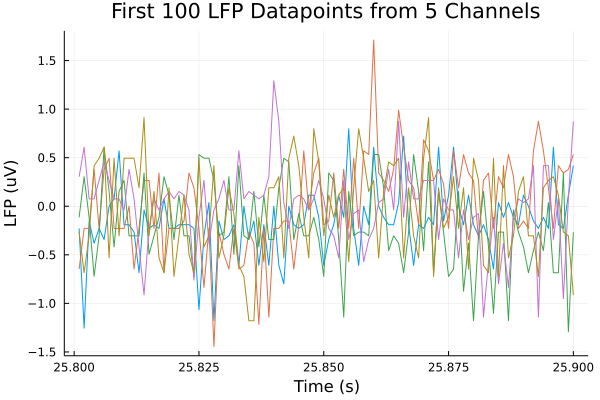

In [24]:
datapoints = 100
channels = 5
plot(lfp_timestamps_extended[1:datapoints], lfp_data[1,1:datapoints], legend=false)
for i in 2:channels
    plot!(lfp_timestamps_extended[1:datapoints], lfp_data[i,1:datapoints], legend=false)
end
title!("First $(datapoints) LFP Datapoints from $(channels) Channels")
xlabel!("Time (s)")
ylabel!("LFP (uV)")

## Importing - Events

In [25]:
events_data = npzread("../../data/formatted-lfp/$(lfp_path)all_channels.npz")

Dict{String, Vector{Float64}} with 7 entries:
  "eventId"         => [1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0  …  0.…
  "channel"         => [7.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0  …  4.…
  "nodeId"          => [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0,…
  "eventType"       => [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0  …  3.…
  "timestamps"      => [25998.0, 27999.0, 28499.0, 38504.0, 39004.0, 49009.0, 4…
  "sampleNumber"    => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.…
  "recordingNumber" => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.…

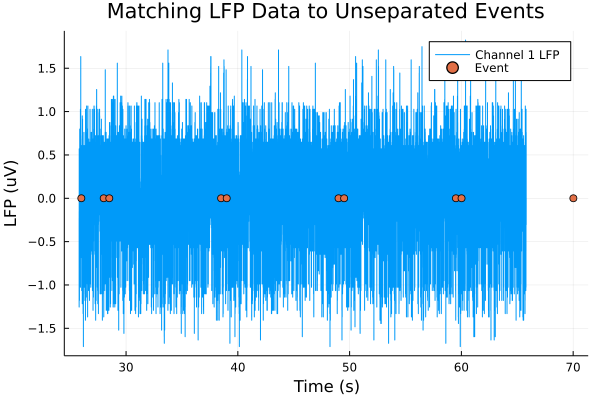

In [26]:
plot(lfp_timestamps_extended[1:40000], lfp_data[1,1:40000], label="Channel 1 LFP")
scatter!(events_data["timestamps"][1:10]./1000, zeros(length(events_data["timestamps"][1:30])), label="Event")
title!("Matching LFP Data to Unseparated Events")
xlabel!("Time (s)")
ylabel!("LFP (uV)")

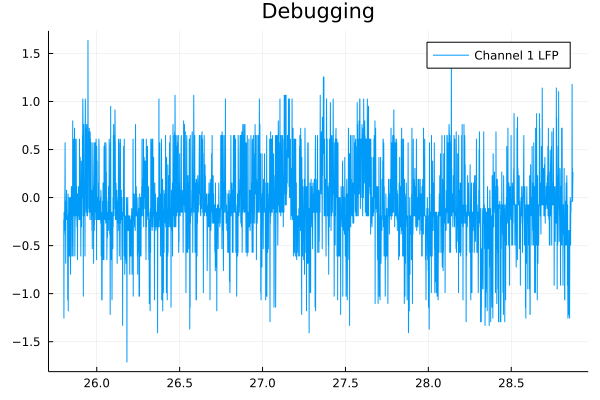

In [27]:
plot(lfp_timestamps_extended[1:3072], lfp_data[1,1:3072], label="Channel 1 LFP")
title!("Debugging")

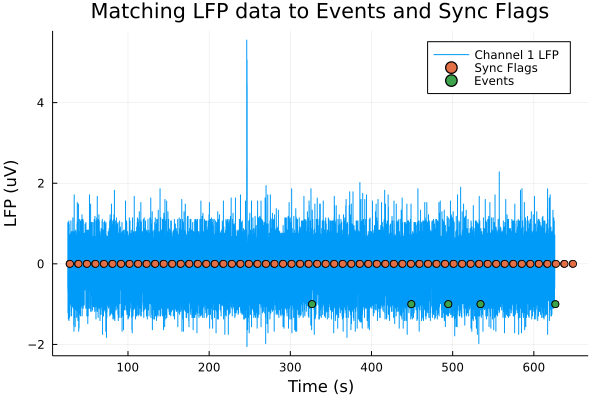

In [28]:
events_separated = []
for event in unique(events_data["channel"])
    push!(events_separated, events_data["timestamps"][findall(x->x==event, events_data["channel"])])
end

plot(lfp_timestamps_extended[1:10:600000], lfp_data[1,1:10:600000], label="Channel 1 LFP")
scatter!(events_separated[2][1:120]./1000, zeros(100), label="Sync Flags")
scatter!(events_separated[3][1:10]./1000, zeros(10).-1, label="Events")

title!("Matching LFP data to Events and Sync Flags")
xlabel!("Time (s)")
ylabel!("LFP (uV)")

## Importing - O2 

In [29]:
# Indexing o2_data[datapoint, time/o2]

o2_path = "Exp 1/R4/"
filename = "o2data R4.txt"
o2_data = []
open("../../data/$(o2_path)$(filename)") do file
    for line in eachline(file)
        if isdigit(line[1])
            data_element = split(line, "\t")
            if length(data_element) == 2
                data_element = [parse(Float32, data_element[1]), parse(Float32, data_element[2]), 0]
            else 
                data_element = [parse(Float32, data_element[1]), parse(Float32, data_element[2]), 1]
            end
            push!(o2_data, data_element)
        end
    end
end
o2_data = reduce(vcat,transpose.(o2_data))
sync_flags = o2_data[findall(x->x==1, o2_data[:,3]), 1]

139-element Vector{Float32}:
   56.792
   67.276
   77.781
   88.283
   98.74
  109.275
  119.808
  130.218
  140.695
  151.252
  161.769
  172.251
  182.671
    ⋮
 1389.955
 1400.437
 1410.359
 1420.911
 1432.146
 1441.838
 1452.663
 1463.423
 1473.59
 1484.011
 1495.252
 1504.788

## Visualisations - O2

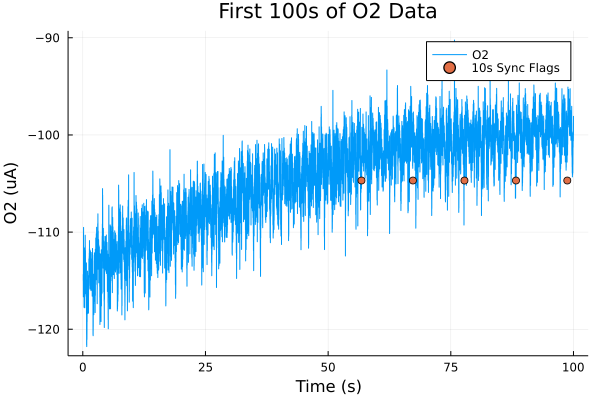

In [30]:
plot(o2_data[1:100000, 1], o2_data[1:100000, 2], label = "O2")
scatter!(sync_flags[1:5], [mean(o2_data[1:100000, 2]) for i in 1:length(sync_flags[1:5])], label = "10s Sync Flags")
title!("First 100s of O2 Data")
xlabel!("Time (s)")
ylabel!("O2 (uA)")